<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование-и-анализ-моделей" data-toc-modified-id="Тестирование-и-анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование и анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Итоги-исследования" data-toc-modified-id="Итоги-исследования-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги исследования</a></span></li></ul></div>

# Классификация комментариев


Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

В нашем распоряжении набор данных с разметкой о токсичности правок.

***Описание данных:***
* Столбец *text* содержит текст комментария
* Столбец *toxic* — целевой признак

***Задачи:***
* Обучить модель классифицировать комментарии на позитивные и негативные
* Построть модель со значением метрики качества $F1 >= 0.75$


## Обзор данных


In [1]:
# импортируем необходимые для работы библиотеки
import re
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from tqdm import notebook

import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# прочитаем и сохраним данные
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')
    

In [3]:
# выведем информацию о располагаемых данных
print(f'\nОбъектов: {df.shape[0]}')
print(f'Признаков: {df.shape[1]}')
print(f'Пропусков: {df.isna().sum().sum()}')
print(f'Дубликатов: {df.duplicated().sum()}')
print('\n\nПервые объекты и признаки:')
display(df.head())
print('\n\nОбщая информация о датафрейме:\n')
df.info()



Объектов: 159571
Признаков: 2
Пропусков: 0
Дубликатов: 0


Первые объекты и признаки:


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0




Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


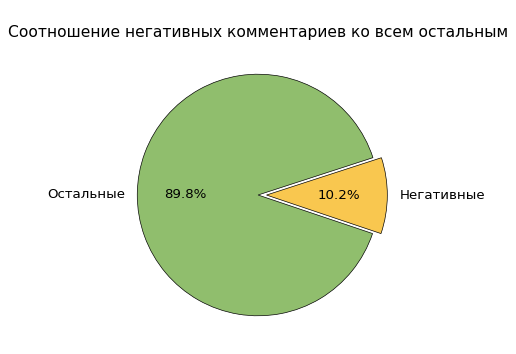

Негативных комментариев: 16225
Остальных комментариев: 143346


In [4]:
# выведем на экран соотношение негативных комментариев ко всем остальным
comments = (df.groupby('toxic')
            .agg({'text': 'count'})
            .reset_index())

plt.figure(figsize=(8, 5), dpi=80)
plt.title('\nСоотношение негативных комментариев ко всем остальным', size=14)

plt.pie(
    x=comments['text'],
    explode=(0, 0.07),
    labels=['Остальные', 'Негативные'],
    colors=['#90BE6D','#F9C74F'],
    startangle = 18,
    autopct='%.1f%%',
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'black', 
                'linewidth': 0.6})

plt.show()


print('Негативных комментариев:',
      df[df['toxic'] == 1]['toxic'].count())

print('Остальных комментариев:',
      df[df['toxic'] == 0]['toxic'].count())


### Выводы
1. Датафрейм содержит 159 571 строку без пропусков, дубликатов и 2 колонки:
  * колонка с комментариями, которые предстоит преобразовать как признаки
  * колонку с целевым признаком
1. Комментарии содержат ненужные для дальнейшей работы знаки (препинания, переносы, апострофы и др.)
1. Выявлен сильный дисбаланс классов (негативных комментариев ~ в 9 раз меньше, чем позитивных или нейтральных)


## Подготовка данных


In [5]:
# упростим текст комментариев
# избавимся от знаков и цифр, проведём стемминг
stemmer = EnglishStemmer()

processed_text = []
for comment in notebook.tqdm(df['text']):
    clear_comment = re.sub(r'[^a-zA-Z]', ' ', comment)
    word_list = clear_comment.split()
    stemm_list = []
    for word in word_list:
        stemm_list.append(stemmer.stem(word))
        edited_comment = ' '.join(stemm_list)
    processed_text.append(edited_comment)


  0%|          | 0/159571 [00:00<?, ?it/s]

In [6]:
# проверим результат упрощения текста
df['processed_text'] = processed_text
df.head()

,text,toxic,processed_text
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m realli not tri to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make ani real suggest on improv i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero ani chanc you rememb what ...


In [7]:
# разделим данные на обучающую и тестовую выборки в пропорции 80/20
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['toxic'],
    test_size=0.2,
    random_state=12,
    stratify=df['toxic'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(127656,) (127656,)
(31915,) (31915,)


In [8]:
# для определения тональности комментарием
# применим величины TF-IDF как признаки
count_tf_idf = TfidfVectorizer() #stop_words=stopwords

tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test = count_tf_idf.transform(X_test)

print(tf_idf_train.shape)
print(tf_idf_test.shape)


(127656, 116045)
(31915, 116045)


In [9]:
# также рассмотрим в качестве признаков
# создание уни- и биграмм для комментариев
count_vect = CountVectorizer(stop_words=stopwords, ngram_range=(1, 2))

n_gramm_train = count_vect.fit_transform(X_train)
n_gramm_test = count_vect.transform(X_test)

print(n_gramm_train.shape)
print(n_gramm_test.shape)


(127656, 1994460)
(31915, 1994460)


### Выводы
1. Проведена очистка комментариев от знаков и цыфр, проведён стемминг слов
1. Данные разделены на обучающую и тестовую выборку с учётом бисбаланса классов
1. Для обучения будущих моделей:
  * расчитаны значения TF-IDF
  * расчитаны N-граммы
  

## Обучение моделей


### LogisticRegression


In [10]:
# передадим LR модели лучшие гиперпараметры
lr_model = LogisticRegression(class_weight = 'balanced',
                              random_state=12,
                              max_iter=500)


### LGBMClassifier


In [11]:
# передадим LGBM модели лучшие гиперпараметры
lgb_model = LGBMClassifier(n_estimators=400,
                          objective='binary',
                          random_state=12)


### Выводы
1. Подобраны гиперпараметры и обучены 2 модели:
  * *LogisticRegression* на TF-IDF в качестве признаков (F1 = 0.750)
  * *LogisticRegression* на N-граммах (F1 = 0.791)
  * *LGBMClassifier* на TF-IDF (F1 = 0.791)
  

## Тестирование и анализ моделей


In [12]:
# напишем функцию для тестирования моделей
# и расчёта времени обучения и предсказания
def test_model(model, X_train, X_test):
    import time
    start = time.time()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    fin_time = round((time.time() - start), 1)
    f1 = round(f1_score(y_test, prediction), 3)
   
    return f1, fin_time


In [13]:
%%time

# создадим списки со значением качесва моделей
# и временем обучения/предсказания
f1_scores, fit_predict_time = [], []

f1, fin_time = test_model(lr_model, tf_idf_train, tf_idf_test)
f1_scores.append(f1)
fit_predict_time.append(fin_time)

f1, fin_time = test_model(lr_model, n_gramm_train, n_gramm_test)
f1_scores.append(f1)
fit_predict_time.append(fin_time)

f1, fin_time = test_model(lgb_model, tf_idf_train, tf_idf_test)
f1_scores.append(f1)
fit_predict_time.append(fin_time)


CPU times: user 25min 19s, sys: 5min 19s, total: 30min 39s
Wall time: 30min 49s


In [14]:
# выведем на экран отчёт с качеством моделей
models = ['LogisticRegression', 'LogisticRegression', 'LGBMClassifier']
features = ['TF-IDF', 'N-grams', 'TF-IDF']

pd.DataFrame(
    {'feature': features, 'f1_score': f1_scores,
     'fit_predict_time, s': fit_predict_time}, index=models)


,feature,f1_score,"fit_predict_time, s"
LogisticRegression,TF-IDF,0.749,82.8
LogisticRegression,N-grams,0.789,700.1
LGBMClassifier,TF-IDF,0.788,1066.9


In [15]:
# напишем функцию для построения ROC-кривой, PR-кривой
# и вычисления метрики AUC-ROC
def metrics_plot(model, features, target): 
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    precision, recall, thresholds = precision_recall_curve(target, probabilities_one_valid)
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    auc_roc = roc_auc_score(target, probabilities_one_valid)

    fig = plt.figure(figsize=(14,5))
    ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)

    ax1.step(recall, precision, where='post')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_title('Кривая Precision-Recall')

    ax2.plot(fpr, tpr)
    ax2.plot([0, 1], [0, 1], linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC-кривая')

    plt.show() 
    
    print(f'Площадь под ROC-кривой (AUC-ROC): {round(auc_roc, 3)}')


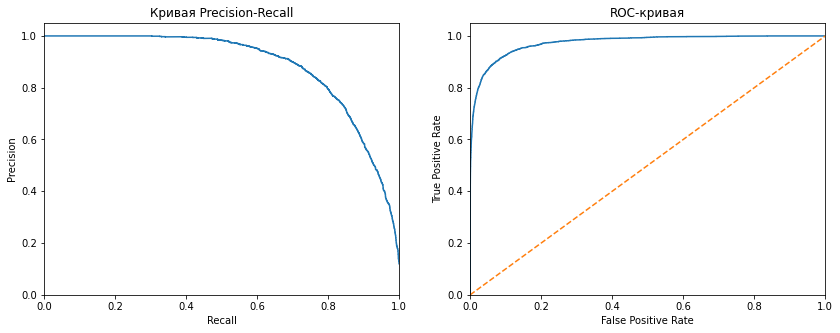

Площадь под ROC-кривой (AUC-ROC): 0.974


In [16]:
# построим ROC и PR-кривую для LGBM модели, 
# модели с лучшим сочетанием качества и скорости обучения/предсказания 
metrics_plot(lgb_model, tf_idf_test, y_test)


### Выводы (*с учетом выполнения расчётов локально*)
1. Проведено тестирование моделей:
  * лучшее качество показала LR модель на N-граммах в качестве признаков (F1 = 0.789)
  * с учётом времени обучения/предсказания — наиболее переспективна LGBM модель с соизмеримым качеством (F1 = 0.788), полученном на TF-IDF в качестве признаков
  * рекордсмен по скорости обучения/предсказания LR модель на TF-IDF в качестве признаков показала значение F1 = 0.749, что немного не соответствует требованиям заказчика (F1 >= 0.750)
  * скорость обучения/предсказания LR модель на TF-IDF в 8 раз выше LGBM и в 30 раз выше LR на N-граммах
1. Построены ROC и PR-кривая для модели с лучшим сочетанием качества и скорости обучения/предсказания (LGBM)
  * PR и ROC-кривая продемонстрировали хорошее качество LGBM модели (доля истинно положительных ответов выше доли ложноположительных)
  * площадь фигуры под ROC-кривой составила 0.974, что также является хорошим показателем и значительно превышает качество константной модели (~ 0.5)


## Итоги исследования
1. Задачи исследования выполнены:
  * модели обучены классифицировать комментарии на позитивные и негативные
  * 2 из 3 моделей удовлетворяют условию исследования — F1 >= 0.75
2. Для интернет-магазина, запускающего новый сервис — наиболее перспективной выглядит LGBM молель с лучшим сочетанием качества и скорости обучения/предсказания


## Bert
Также сейчас активно используются RNN (LSTM) и трансформеры (BERT, ELMO, GPT/2/3/n и др.). Они не являются панацеей, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут решать задачи в текстах. \
BERT тяжелый, есть готовые модели, есть надстройки над библиотекой transformers. Если обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.

<font color='green'>Пример BERT с GPU:
```python
%%time
from tqdm import notebook
batch_size = 2 # для примера возьмем такой батч, где будет всего две строки датасета
embeddings = [] 
for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
        batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
        
        with torch.no_grad():
            model.cuda()
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
        del batch
        del attention_mask_batch
        del batch_embeddings
        
features = np.concatenate(embeddings) 
```
Можно сделать предварительную проверку на наличие GPU.\
Например, так: ```device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")```\
Тогда вместо .cuda() нужно писать .to(device)</font>